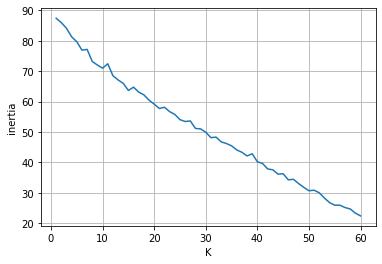

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from wordcloud import WordCloud


def load_pickle(path):
    df = pd.read_pickle(path)
    df['skills'] = df['skills'].apply(lambda x: "".join(x))
    return df

def tfidf_conversion(df, col):
    vectorizer = TfidfVectorizer(stop_words='english')
    tfidf_matrix = vectorizer.fit_transform(df[col])
    tfidf_np_mat = tfidf_matrix.toarray()
    return tfidf_np_mat

def shrink_matrix(matrix, num=100):
    svd = TruncatedSVD(n_components=num)
    short_matrix = svd.fit_transform(matrix)
    return normalize(short_matrix)

def find_k_values(matrix, k_low, k_high):
    k_values = range(k_low, k_high)
    inertia = [MiniBatchKMeans(k).fit(matrix).inertia_ 
              for k in k_values]
    plt.plot(k_values, inertia)
    plt.xlabel('K')
    plt.ylabel('inertia')
    plt.grid(True)
    
df = load_pickle('output/step2_df.pk')
tfidf_mat = tfidf_conversion(df, 'skills')
shrink_mat = shrink_matrix(tfidf_mat)
find_k_values(shrink_mat, 1, 61)

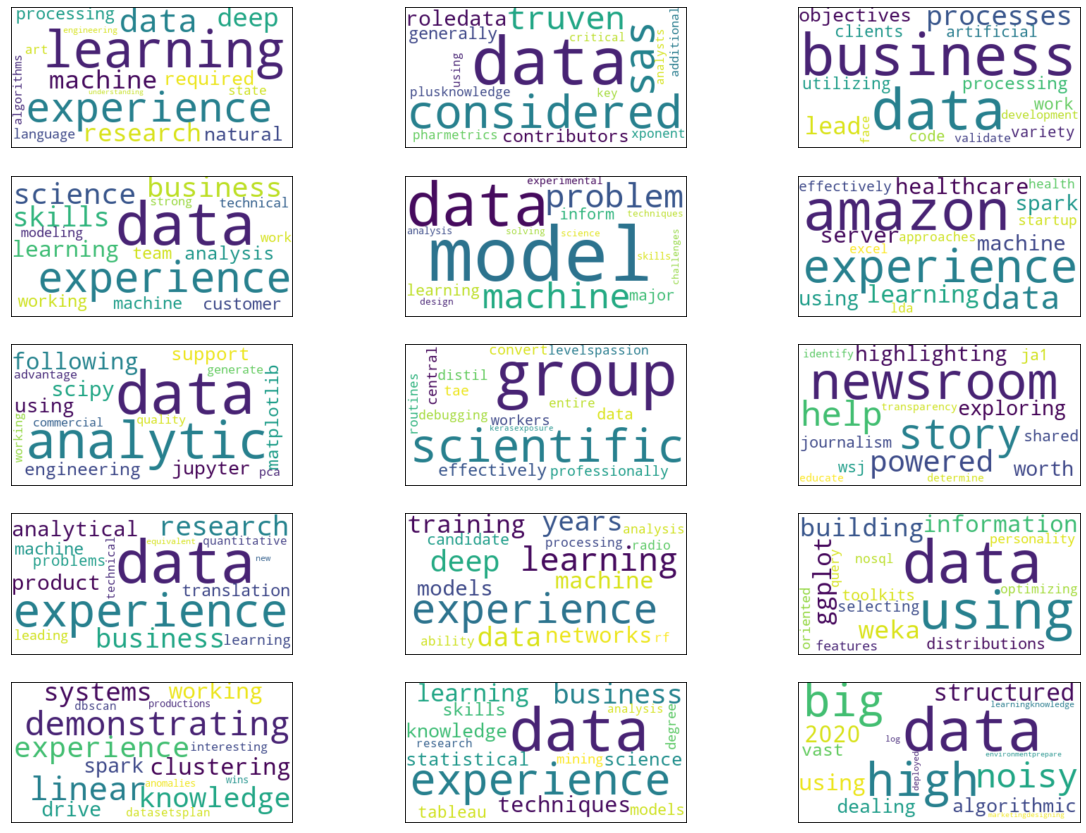

In [6]:
text = df['skills'].values
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(text)

def k_clusters(matrix, col, k=15):
    cluster_model = KMeans(n_clusters=k)
    cluster = cluster_model.fit_predict(matrix)
    df = pd.DataFrame({'Index':range(cluster.size), 'Cluster':cluster,
                      'Text': col})
    return df

def rank_words_by_tfidf(indices, vectorizer=vectorizer, 
                        tfidf_matrix=tfidf_matrix):
    summed_tfidf = np.asarray(tfidf_matrix[indices].sum(axis=0))[0]
    words = vectorizer.get_feature_names()
    data = {'Word': words,
            'Summed TFIDF': summed_tfidf}
    return pd.DataFrame(data).sort_values('Summed TFIDF', ascending =False)

def display_word_cloud(df, idx, max_words=15):
    index = df[df['Cluster'] == idx].Index.values
    df_rank = rank_words_by_tfidf(index)[:max_words]
    words_to_score = {word: score
                      for word,score in df_rank[:max_words].values}
    cloud_generator = WordCloud(background_color='white',
                            random_state=1)
    wordcloud_image = cloud_generator.fit_words(words_to_score)
    return plt.imshow(wordcloud_image)

def display_cloud(df,max_value=15):
    index = df.Index.values
    df_rank = rank_words_by_tfidf(index)[:max_value]
    words_to_score = {word: score
                      for word,score in df_rank[:max_value].values}
    cloud_generator = WordCloud(background_color='white',
                            random_state=1)
    wordcloud_image = cloud_generator.fit_words(words_to_score)
    return wordcloud_image

def multi_word_cloud(df, num_rows=5, num_cols=3):
    figure, axes = plt.subplots(num_rows, num_cols, figsize=(20,15))
    cluster_groups = list(df.groupby('Cluster'))
    for row in range(num_rows):
        for column in range(num_cols):
            _, df_cluster = cluster_groups.pop(0)
            wordcloud_image = display_cloud(df_cluster, max_value=15)
            ax = axes[row][column]
            ax.imshow(wordcloud_image,
                 interpolation='bilinear')
            ax.set_xticks([])
            ax.set_yticks([])

df_new = k_clusters(shrink_mat, text, k=15)
multi_word_cloud(df_new)